<span style="font-size:24px;">Customer Segmentation using RFM Analysis.</span>





<span style="font-size:24px;">1. Setup & Data Loading.</span>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans


In [2]:
df = pd.read_csv(r"/Users/jojo/Downloads/Online Retail 1(Online Retail).csv", encoding='latin1')


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<span style="font-size:24px;">2.Data Cleaning</span>

In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
for col in df.columns:
    if df[col].dtype.kind in "bifc":  
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode().iloc[0])

In [9]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
# Remove cancelled orders (InvoiceNo starting with "C")
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

In [11]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [12]:
df["CustomerID"] = df["CustomerID"].astype(int) 
df.dtypes  

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

In [13]:
# Create TotalPrice column
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


<span style="font-size:24px;">3. RFM</span>

In [26]:
# Calculate RFM Metrics
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                  # Frequency
    "TotalPrice": "sum"                                      # Monetary
}).reset_index()

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


<span style="font-size:24px;">4. Assign RFM Scores.</span>


In [27]:
# Assign RFM Scores (1 to 4)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346,326,1,77183.60,1,1,4
1,12347,2,7,4310.00,4,4,4
2,12348,75,4,1797.24,2,3,4
3,12349,19,1,1757.55,3,1,4
4,12350,310,1,334.40,1,1,2


In [28]:
# Create RFM Segment and Score
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].astype(int).sum(axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346,326,1,77183.60,1,1,4,114,6
1,12347,2,7,4310.00,4,4,4,444,12
2,12348,75,4,1797.24,2,3,4,234,9
3,12349,19,1,1757.55,3,1,4,314,8
4,12350,310,1,334.40,1,1,2,112,4


<span style="font-size:24px;">5. Customer Segmentation.</span>

In [29]:
# Define Customer Groups
def segment_customer(score):
    if score >= 9:
        return "Champions"
    elif score >= 7:
        return "Loyal Customers"
    elif score >= 5:
        return "Potential Loyalist"
    else:
        return "At Risk"

rfm["Customer_Segment"] = rfm["RFM_Score"].apply(segment_customer)


Marketing Ideas
Champions - Marketing Actions:

Reward them with exclusive offers or VIP programs
Encourage referrals and reviews
Give early access to new products
Loyal Customers - Marketing Actions:

Offer loyalty discounts or points program
Upsell higher-value products
Send personalized thank-you emails
Potential Loyalist - Marketing Actions:

Offer limited-time discounts to encourage repeat purchase
Recommend products based on browsing/purchase history
Target them with email campaigns
Needs Attention - Marketing Actions:

Send reminder emails or reactivation campaigns
Offer moderate discounts or incentives
Highlight trending/popular products to re-engage
At Risk - Marketing Actions:

Send strong win-back campaigns with special discounts
Survey them to understand why they stopped buying
Offer bundled deals or freebies


In [18]:
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0       12346      326          1  77183.60       1       1       4   
1       12347        2          7   4310.00       4       4       4   
2       12348       75          4   1797.24       2       3       4   
3       12349       19          1   1757.55       3       1       4   
4       12350      310          1    334.40       1       1       2   

  RFM_Segment  RFM_Score    Customer_Segment  
0         114          6  Potential Loyalist  
1         444         12           Champions  
2         234          9           Champions  
3         314          8     Loyal Customers  
4         112          4             At Risk  


<span style="font-size:24px;">6. Visualizations.</span>

/var/folders/v9/50_fgfdx7d9ddx3p4n70cxtc0000gn/T/ipykernel_3545/1182882513.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x="Customer_Segment", order=rfm["Customer_Segment"].value_counts().index, palette="viridis")


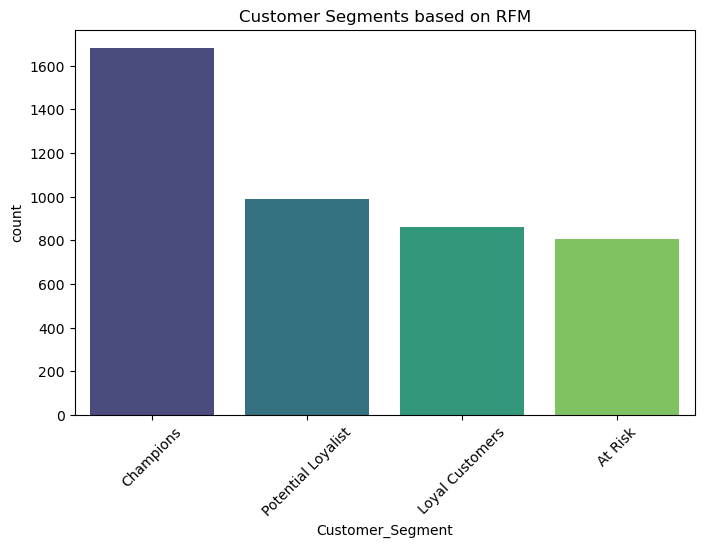

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of Segments
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x="Customer_Segment", order=rfm["Customer_Segment"].value_counts().index, palette="viridis")
plt.title("Customer Segments based on RFM")
plt.xticks(rotation=45)
plt.show()

<span style="font-size:24px;">7. Marketing Ideas.</span>

In [35]:
# Marketing Ideas
marketing_strategies = {
    "Champions": "Reward them with discounts, early access to new products.",
    "Loyal Customers": "Build loyalty programs, personalized recommendations.",
    "Potential Loyalist": "Offer incentives to buy again, targeted promotions.",
    "At Risk": "Send re-engagement campaigns, special offers to win back."
}

print("\nMarketing Strategies by Segment:")
for seg, strat in marketing_strategies.items():
    print(f"{seg}: {strat}")



Marketing Strategies by Segment:
Champions: Reward them with discounts, early access to new products.
Loyal Customers: Build loyalty programs, personalized recommendations.
Potential Loyalist: Offer incentives to buy again, targeted promotions.
At Risk: Send re-engagement campaigns, special offers to win back.


<span style="font-size:30px;">BONUS</span>

<span style="font-size:24px;">1. Bar Chart of Customer Segments</span>

/var/folders/v9/50_fgfdx7d9ddx3p4n70cxtc0000gn/T/ipykernel_3545/3822403261.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x="Customer_Segment",


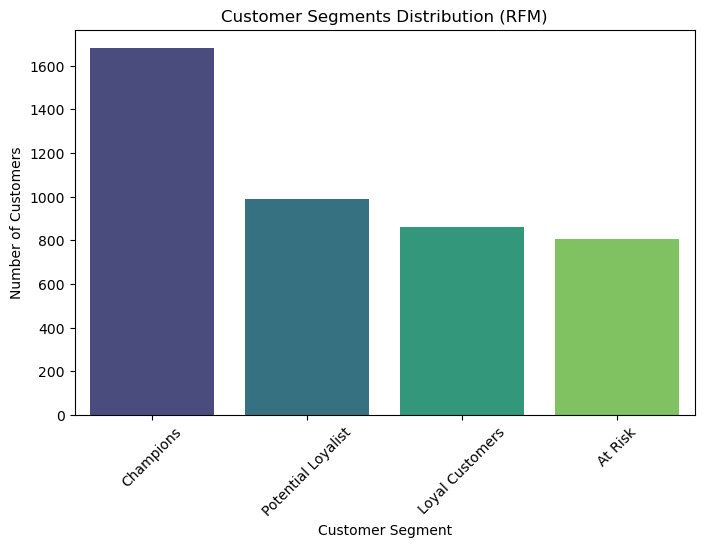

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Bar Chart of Customer Segments
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x="Customer_Segment",
              order=rfm["Customer_Segment"].value_counts().index,
              palette="viridis")
plt.title("Customer Segments Distribution (RFM)")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()


<span style="font-size:24px;">2. Heatmap of Average RFM Scores by Segments.</span>

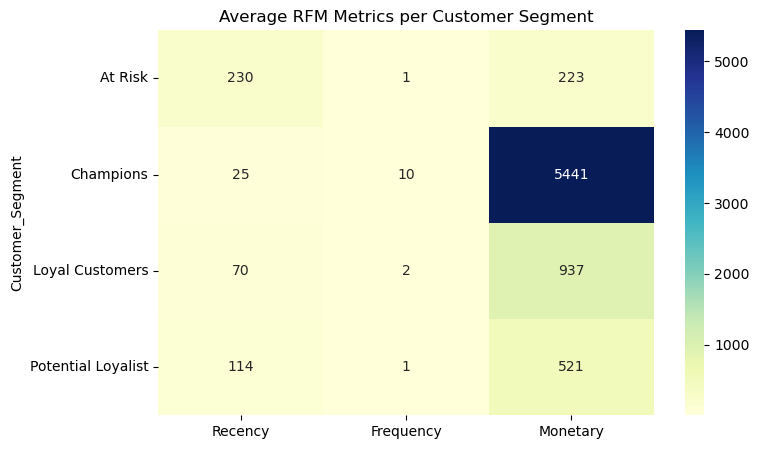

In [37]:
# 2) Heatmap of Average RFM Scores by Segment
rfm_heatmap = rfm.groupby("Customer_Segment")[["Recency","Frequency","Monetary"]].mean()

plt.figure(figsize=(8,5))
sns.heatmap(rfm_heatmap, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average RFM Metrics per Customer Segment")
plt.show()


<span style="font-size:24px;">3. RFM Score Distribution.</span>

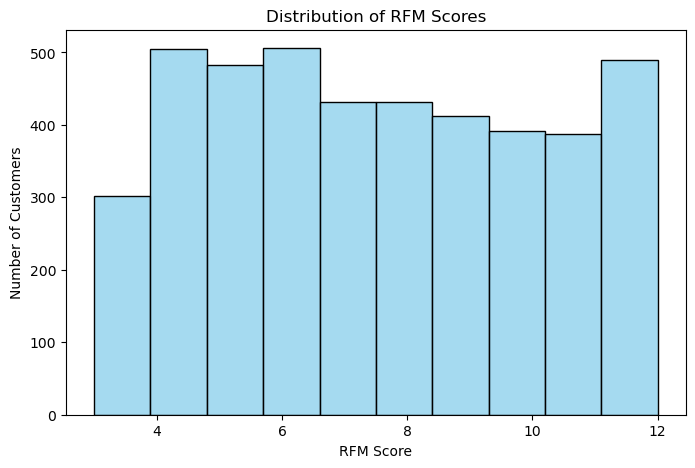

In [38]:
# 3) RFM Score Distribution 
plt.figure(figsize=(8,5))
sns.histplot(rfm["RFM_Score"], bins=10, kde=False, color="skyblue")
plt.title("Distribution of RFM Scores")
plt.xlabel("RFM Score")
plt.ylabel("Number of Customers")
plt.show()